<a href="https://colab.research.google.com/github/mtsizh/galaxy-morphology-manifold-learning/blob/main/clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download images from GitHub (Instead of this code you can upload yor own archive and unzip it).

In [ ]:
!wget -q https://raw.githubusercontent.com/mtsizh/galaxy-morphology-manifold-learning/main/curated_dataset/curated_imgs_multipart.zip && echo "HEAD dowloaded" || "ERROR downloading HEAD"

for i in range(1,8):
  !wget -q https://raw.githubusercontent.com/mtsizh/galaxy-morphology-manifold-learning/main/curated_dataset/curated_imgs_multipart.z0{i}  && echo "PART {i} of 7 OK" || "ERROR downloading PART {i}"

print('MERGING PARTS')
!zip -FF curated_imgs_multipart.zip --out curated_imgs.zip > /dev/null && rm curated_imgs_multipart.z* && echo "COMPLETE" || "FAILED"

!unzip -q -o curated_imgs.zip && echo "UNZIPPED" || "FAIL"

HEAD dowloaded
PART 1 of 7 OK
PART 2 of 7 OK
PART 3 of 7 OK
PART 4 of 7 OK
PART 5 of 7 OK
PART 6 of 7 OK
PART 7 of 7 OK
MERGING PARTS
COMPLETE
UNZIPPED


Perform dimensionality reduction with best parameters.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.manifold import LocallyLinearEmbedding
from tqdm.auto import tqdm
from PIL import Image
import pickle


n_neighbors = 10
n_components = 138
n_bootstrap_samples = 20000


df = pd.read_parquet('curated_dataset.parquet')
bootstrapped_df = df.sample(n=n_bootstrap_samples)
X = np.zeros((len(bootstrapped_df), 120, 120))

print('LOAD IMAGES')
paths = bootstrapped_df['png_loc'].str.replace('dr5', 'curated_imgs')
with tqdm(total=len(paths)) as progress:
  for idx, file_path in enumerate(paths):
    with Image.open(file_path) as img:
      X[idx,:,:] = np.array(img)
      progress.update()

print('CALCULATE LLE')
X_flattened = X.reshape(X.shape[0], -1)
lle = LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=n_components)
X_embedded = lle.fit_transform(X_flattened)


out_file = f'unsupervised_LLE_{n_components}_neighbours_{n_neighbors}.pkl'.replace(' ', '_')
print('SAVING to: ', out_file)
with open(out_file, 'wb') as f:
  pickle.dump({'X_embedded': X_embedded,
               'metadata': bootstrapped_df}, f)
print('COMPLETE')

LOAD IMAGES


  0%|          | 0/20000 [00:00<?, ?it/s]

CALCULATE LLE
SAVING to:  unsupervised_LLE_138_neighbours_10.pkl
COMPLETE


Install library for Dunn index calculation (Davis-Bolduin already implemented in sklearn).

In [2]:
!pip install git+https://github.com/jqmviegas/jqm_cvi.git

  Cloning https://github.com/jqmviegas/jqm_cvi.git to /tmp/pip-req-build-38zx0g9t
  Running command git clone --filter=blob:none --quiet https://github.com/jqmviegas/jqm_cvi.git /tmp/pip-req-build-38zx0g9t
  Resolved https://github.com/jqmviegas/jqm_cvi.git to commit 9e1137d4f4df70c1287011e1a544b0c3fe36af36
  Preparing metadata (setup.py) ... done
  Created wheel for jqmcvi: filename=jqmcvi-1.0-cp311-cp311-linux_x86_64.whl size=450014 sha256=e938223a71a5cd05ad36b0580cb6a212eb771eae9efc72a50dd116712abb48d3
  Stored in directory: /tmp/pip-ephem-wheel-cache-7l94hia6/wheels/29/10/d5/511cfe31e24f6431d3c2b84287074fe8d1c92c2128f93bdc9c
Successfully built jqmcvi


Calculate indices and dump data for further plotting.

In [56]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from jqmcvi import base
import pickle
import numpy as np
from tqdm.auto import tqdm
import json
import os

# Configurations
load_from = 'unsupervised_LLE_138_neighbours_10.pkl'
sample_size = 1000
n_iterations = 1000
calc_dunn = True  # Very slow
dump_file = './scores.json'
cluster_range = range(2, 10)  # Cluster range for evaluation

def get_scores(X, calc_db=True, calc_dunn=True, calc_elbow=True, calc_silhouette=True):
  scores = {
    'db': [], 'dunn': [], 'elbow': [], 'silhouette': []
  }

  for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X)

    if calc_db:
      scores['db'].append(davies_bouldin_score(X, labels))
    if calc_dunn:
      points_by_cluster = [X[labels == c] for c in range(n_clusters)]
      scores['dunn'].append(base.dunn(points_by_cluster))
    if calc_elbow:
      scores['elbow'].append(kmeans.inertia_)
    if calc_silhouette:
      if len(set(labels)) > 1:  # Silhouette score requires at least 2 clusters
        scores['silhouette'].append(silhouette_score(X, labels))
      else:
        scores['silhouette'].append(0.0)  # Invalid case

  return scores

# Load data
with open(load_from, 'rb') as f:
  data = pickle.load(f)
  X_embedded = data['X_embedded']

# Load existing scores or initialize
if os.path.isfile(dump_file):
  with open(dump_file, 'r') as f:
    all_scores = json.load(f)
  already_processed = max([len(all_scores[n]) for n in ['db', 'dunn', 'elbow', 'silhouette']])
  n_iterations -= already_processed
  print(f'Already processed {already_processed}, remaining iterations: {n_iterations}')
else:
  all_scores = {'db': [], 'dunn': [], 'elbow': [], 'silhouette': []}

# Perform clustering and score calculation
try:
  with tqdm(total=n_iterations) as progress:
    for _ in range(n_iterations):
      row_indices = np.random.choice(X_embedded.shape[0], size=sample_size, replace=False)
      sample = X_embedded[row_indices]
      scores = get_scores(sample, calc_dunn=calc_dunn)

      for key in all_scores:
        if scores[key]:
          all_scores[key].append(scores[key])

      with open(dump_file, 'w') as out_file:
        json.dump(all_scores, out_file)

      progress.update()
except KeyboardInterrupt:
  print("Execution stopped by user. Exiting gracefully.")


Already processed 1000, remaining iterations: 0


0it [00:00, ?it/s]

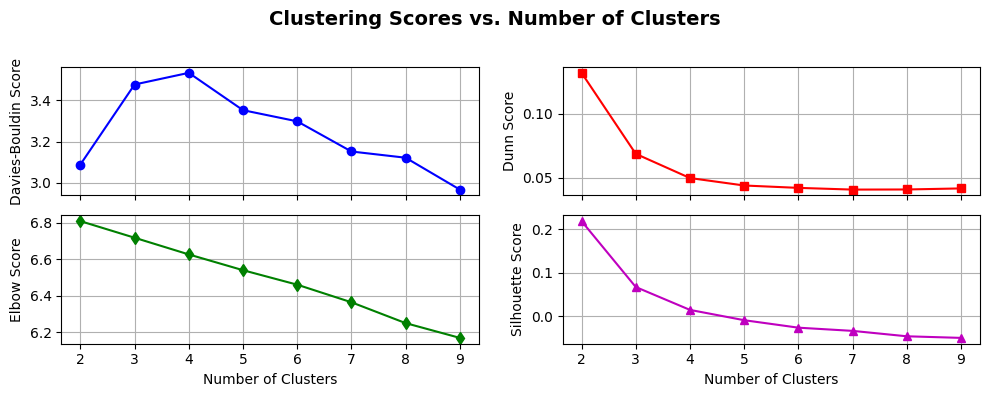

In [58]:
import matplotlib.pyplot as plt
import json
import numpy as np

# Load the scores from file
dump_file = './scores.json'

with open(dump_file, 'r') as in_file:
  all_scores = json.load(in_file)

# Convert lists to NumPy arrays and compute means
db_scores = np.mean(np.array(all_scores['db']), axis=0)
dunn_scores = np.mean(np.array(all_scores['dunn']), axis=0)
elbow_scores = np.mean(np.array(all_scores['elbow']), axis=0)
silhouette_scores = np.mean(np.array(all_scores['silhouette']), axis=0)

clusters = np.arange(2, 10)  # X-axis values

# Create subplots (2x2 grid)
fig, axes = plt.subplots(2, 2, figsize=(10, 4), sharex=True)
fig.suptitle("Clustering Scores vs. Number of Clusters", fontsize=14, fontweight="bold")

# Plot Davies-Bouldin Score
axes[0, 0].plot(clusters, db_scores, marker='o', linestyle='-', color='b')
axes[0, 0].set_ylabel("Davies-Bouldin Score")
axes[0, 0].grid(True)

# Plot Dunn Score (if available)
if np.any(dunn_scores):
  axes[0, 1].plot(clusters, dunn_scores, marker='s', linestyle='-', color='r')
axes[0, 1].set_ylabel("Dunn Score")
axes[0, 1].grid(True)

# Plot Elbow Score (Inertia)
axes[1, 0].plot(clusters, elbow_scores, marker='d', linestyle='-', color='g')
axes[1, 0].set_ylabel("Elbow Score")
axes[1, 0].set_xlabel("Number of Clusters")
axes[1, 0].grid(True)

# Plot Silhouette Score (if available)
if np.any(silhouette_scores):
  axes[1, 1].plot(clusters, silhouette_scores, marker='^', linestyle='-', color='m')
axes[1, 1].set_ylabel("Silhouette Score")
axes[1, 1].set_xlabel("Number of Clusters")
axes[1, 1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
plt.show()
